# Main code for generating results (assignment 1)


In [39]:
#imports
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import queue
import shelve
from statistics import NormalDist
import seaborn as sns
import pandas as pd
import scipy
from scipy.stats import t, f
from statsmodels.stats import multitest 

# plot settings
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

TEX_PLOTS = True

if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [40]:
from cpp_stoch import (
    f_c as f_c_cpp,
    mandelbrot_grid
)

from helpers import Monte_carlo, I_iter_worker, S_iter_worker, \
  uniform_sampler, latin_square_sampler, orthogonal_sampler, N_iter_worker,  \
  scrambled_sobol_sampler

In [42]:
# RNG initialization for parallel sampling
#  see https://albertcthomas.github.io/good-practices-random-number-generators/
#  and https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html#numpy.random.MT19937
from numpy.random import Generator, MT19937, SeedSequence

def initialize_parallel_rngs(n, seed):
    """
    Initializes `n` Mersenne Twister PRNGs and advance each PRGNS by 2^128 steps to avoid
    problems in parallel sampling as described in https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html#numpy.random.MT19937.
    
    Returns:
        List of PRNGs safe for parallel sampling use
    """
    sg = SeedSequence(seed)
    bit_generator = MT19937(sg)
    rngs = []
    for _ in range(n):
        rngs.append(Generator(bit_generator))
        bit_generator = bit_generator.jumped()
        
    return rngs

### Statistical tools

In [4]:
from scipy import stats

def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [5]:
def Statistics_print(Approx_areas_list, sample_size_range):
    """ Prints various statistical properties for each value in a range:
            Mean, Error, Confidence radius, Standard deviation    
    """
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    a = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]
    Error = np.abs(Area_means- Area_means[-1])
    print("Means: ", Area_means)
    print("Error: ", Error)
    print("Confidence radius: ", a)
    print("Std: ", Area_std)

In [6]:
def F_test(Samples_A, Samples_B):
    """ Calculates the F-test based on the data from two datasets.
        Returns:
            F-statistics (int)
            p=value (int)
    """
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    F = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    p_value = 1 - scipy.stats.f.cdf(F, (n1 - 1), (n2 - 1))
    return F, p_value

### Iteration functions

These functions are used to generate results with a varying parameter, such as the sample size, the number of iterations and the number of runs.  

In [43]:
def S_iter(max_iter, n_runs, S_min_exp, S_max_exp, seed, sampling_method = uniform_sampler, steps = 4):
    """ Calculates the approximated Mandelbrot Area for various values of the sample size.
        This is done a log-scale, starting from the smallest exponent (S_min_exp) to the largest exponent (S_max_exp)
        This is done for multiple runs (n_runs). 
        The standard sampling method is uniform_sampler, but latin_square_sampler, orthogonal_sampler
         or scrambled_sobol_sampler can also be used. 
        
    Returns:
        List of lists, where inner list is the results for n runs and outer list for the various sample sizes. 
        List of sample sizes used. 
    """    
    
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    sample_size_range = np.logspace(S_min_exp, S_max_exp, num = ((S_max_exp - S_min_exp) + 1)*steps, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for sample_size in sample_size_range:
            work_queue.put((sample_size, i))


    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []
    # divide work evenly over CPU's
    for i in range(mp.cpu_count()):
        p = mp.Process(target=S_iter_worker, args=(
            work_queue, Approx_areas_list, max_iter, rngs[i], sampling_method
        ))
        p.daemon = True
        p.start()
        processes.append(p)


    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], sample_size_range        

In [44]:
def I_iter(sample_size, n_runs, I_min_exp, I_max_exp, seed, sampling_method = uniform_sampler, steps = 4):
    """ Calculates the approximated Mandelbrot Area for various values of the iteration number.
        This is done a log-scale, starting from the smallest exponent (S_min_exp) to the largest exponent (S_max_exp)
        This is done for multiple runs (n_runs). 
        The standard sampling method is uniform_sampler, but latin_square_sampler, orthogonal_sampler
         or scrambled_sobol_sampler can also be used. 
        
    Returns:
        List of lists, where inner list is the results for n runs and outer list for the various iteration numbers. 
        List of iteration numbers used. 
    """    
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    iteration_range = np.logspace(I_min_exp, I_max_exp, num = ((I_max_exp - I_min_exp) + 1)*steps, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for max_iter in iteration_range:
            work_queue.put((max_iter, i))

    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []
    # divide work evenly over CPU's
    for i in range(mp.cpu_count()):
        p = mp.Process(target=I_iter_worker, args=(
            work_queue, Approx_areas_list, sample_size, rngs[i], sampling_method 
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], iteration_range

In [45]:
def N_iter(S_fix, I_fix, sampling_method, seed):  
    """ Calculates the approximated Mandelbrot Area for various values of the number of runs.
        The sample size (S_fix) and number of iterations (I_fix) is fixed. 
        This is done a linear scale (10 to 1000 runs, with 20 steps).
        The standard sampling method is uniform_sampler, but latin_square_sampler, orthogonal_sampler
        or scrambled_sobol_sampler can also be used. 
        
    Returns:
        Dictionary, where the key is the number of runs, and the value the approximated area for each run. 
        List of number of runs used. 
    """   
    manager = mp.Manager()

    Approx_areas_list = manager.dict()  
    runs_size_range = np.linspace(10, 1000, 20, dtype = int)
    work_queue = mp.Queue()
    
    for runs_size in runs_size_range:
        Approx_areas_list[runs_size] = manager.list()
        
        for i in range(runs_size):
            work_queue.put((runs_size, i))

        rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
        processes = []
        # divide work evenly over CPU's
        for i in range(mp.cpu_count()):
            p = mp.Process(target=N_iter_worker, args=(
                work_queue, Approx_areas_list, S_fix, I_fix, rngs[i], sampling_method
            ))
            p.daemon = True
            p.start()
            processes.append(p)


        for p in processes:
            p.join()

    return {k: list(v) for k, v in Approx_areas_list.copy().items()}, runs_size_range    

### Plotter functions

In [47]:
def Plotter_S(Approx_areas_list, sample_size_range):
    """ Plotter function for the results generated with the S_iter function. 
        Produces a plot from the corresponding data. 
    """
    
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    a_scipy = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]

    Error = np.abs(Area_means - Area_means[-1])
    fig,ax = plt.subplots(figsize=(5.25, 4))
    
    plt.grid(alpha=0.2)
    
    ax.plot(sample_size_range, Area_means, marker=".", color = "tab:blue", zorder=3)
    ax.fill_between(sample_size_range, Area_means - a_scipy, Area_means + a_scipy, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(sample_size_range, Error, color = "black", linestyle='dashed', zorder=1)
    ax2.set_ylim(-0.05, 0.65)
    
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.6)
    ax.yaxis.label.set_color('tab:blue')

    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $\\overline{A}_{s}$")
        ax.set_xlabel("Number of samples ($s$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert \\overline{A}_{s_\\text{max}} - \\overline{A}_{s_j}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_s.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_ns")
        ax.set_xlabel("Number of samples (s)")
        ax2.set_ylabel("Difference mean area (|A_smax - A_i|)")
    
    plt.show()

In [48]:
def Plotter_I(Approx_areas_list, iteration_range):
    """ Plotter function for the results generated with the I_iter function. 
        Produces a plot from the corresponding data. 
    
    """    
    
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    a_scipy = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]
    Error = np.abs(Area_means - Area_means[-1])
   
    fig,ax = plt.subplots(figsize=(5.25, 4))
    plt.grid(alpha=0.2)
    
    ax.plot(iteration_range, Area_means, marker=".", color = "tab:blue", zorder=3)
    ax.fill_between(iteration_range, Area_means - a_scipy, Area_means + a_scipy, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(iteration_range, Error, color = "black", linestyle='dashed', zorder=1)
            
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.6)
    ax.yaxis.label.set_color('tab:blue')
    ax2.set_ylim(-0.05, 0.65)
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $\\overline{A}_{n}$")
        ax.set_xlabel("Number of iterations ($n$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert \\overline{A}_{n_\\text{max}} - \\overline{A}_{n_j}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_i.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_ns")
        ax.set_xlabel("Number of iteration (i)")
        ax2.set_ylabel("Difference mean area (A_n_maxs - A_n_js)")

    plt.show()

In [49]:
def Plotter_N(Dic_PRS, Dic_LHS, Dic_OS):
    """ Plotter function to compare different sampling techniques. 
        Inputs are the dictionaries generated with N-iter for the sampling techniques of: 
            - PRS
            - LHS
            - OS         
        Produces a plot from the corresponding data. 
    """    
    
    Sampling_methods = [Dic_PRS, Dic_LHS, Dic_OS]
    fig,ax = plt.subplots(figsize=(5.25, 4))
    fig2,ax2 = plt.subplots(figsize=(5.25, 4))
    run_size_range = list(Dic_PRS.keys())
    
    for Sampling_method in Sampling_methods:
        Approx_areas_list = list(Sampling_method.values())
        
        Area_means = []
        a_scipy = []
        
        for row in Approx_areas_list:
            mean = sum(row)/len(row)
            a = sp_confidence_interval(row)
            Area_means.append(mean)
            a_scipy.append(a)  
        
        Area_means = np.array(Area_means)
        a_scipy = np.array(a_scipy)
        
        Error = np.abs(Area_means - Area_means[-1])
        ax2.plot(run_size_range, Error, linestyle='dashed')
        
        ax.fill_between(run_size_range, Area_means - a_scipy, Area_means + a_scipy, alpha=0.2)
        ax.plot(run_size_range, Area_means, marker=".")
    
    ax.legend(["PRS", "LHS", "OS"]), ax2.legend(["PRS", "LHS", "OS"])
    ax.grid(alpha=0.2), ax2.grid(alpha=0.2)    
    
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $\\overline{A}_{R}$")
        ax.set_xlabel("Number of runs ($r$)")
        ax2.set_xlabel("Number of runs ($r$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert \\overline{A}_{r_\\text{max}} - \\overline{A}_{r_j}\\right\\rvert$")
        fig.savefig('figures/comparison_means_N.pdf', bbox_inches='tight')
        fig2.savefig('figures/comparison_differences_N.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of runs (R)")
        ax2.set_xlabel("Number of runs (R)")
        ax2.set_ylabel("Difference mean area (A_js - A_is)")

    plt.show()

In [52]:
def Plotter_N_Quasi(Quasi, OS, Quasi_sobol):
    """ Plotter function to compare different sampling techniques. 
        Inputs are the dictionaries generated with N-iter for the sampling techniques of: 
            - OS  
            - QRMC 
        Produces a plot from the corresponding data. 
    """
    
    Sampling_methods = [OS, Quasi_sobol]
    fig,ax = plt.subplots(figsize=(5.25, 4))
    fig2,ax2 = plt.subplots(figsize=(5.25, 4))
    run_size_range = list(Quasi.keys())
    colors = ("tab:green", "tab:red")
    
    
    for i, Sampling_method in enumerate(Sampling_methods):
        Approx_areas_list = list(Sampling_method.values())
        
        Area_means = []
        a_scipy = []
        
        for row in Approx_areas_list:
            mean = sum(row)/len(row)
            a = sp_confidence_interval(row)
            Area_means.append(mean)
            a_scipy.append(a)  
        
        Area_means = np.array(Area_means)
        a_scipy = np.array(a_scipy)
        
        Error = np.abs(Area_means - Area_means[-1])
        ax2.plot(run_size_range, Error, linestyle='dashed', color=colors[i])
        ax.fill_between(run_size_range, Area_means - a_scipy, Area_means + a_scipy, alpha=0.1, color=colors[i])
        ax.plot(run_size_range, Area_means, color=colors[i], marker=".")
    
    ax.legend(["OS", "RQMC (Sobol)"]), ax2.legend(["OS", "RQMC (Sobol)"])
    ax.grid(alpha=0.2), ax2.grid(alpha=0.2)    
    #ax.set_ylim(1.495, 1.517)
    #ax2.set_ylim(0, 0.005)
    
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $\\overline{A}_{r}$")
        ax.set_xlabel("Number of runs ($r$)")
        ax2.set_xlabel("Number of runs ($r$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert \\overline{A}_{r_\\text{max}} - \\overline{A}_{r_j}\\right\\rvert$")
        fig.savefig('figures/comparison_os_qmc.pdf', bbox_inches='tight')
        fig2.savefig('figures/differences_os_qmc.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of runs (r)")
        ax2.set_ylabel("Difference mean area (A_js - A_is)")

    plt.show()

### Results for varying values of the sample size and iteration number

These results correspond to research objective 1 within the paper. For these results the Pure Random Sampling method is used. 

In [53]:
#%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/S_iter")
#Approx_areas_list_S_Uni, sample_size_range_S_Uni = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 1, S_max_exp = 7, seed=523235)
#shelf["Approx_areas_list_S_Uni"] = Approx_areas_list_S_Uni
#shelf["sample_size_range_S_Uni"] = sample_size_range_S_Uni
#shelf.close()

In [54]:
# Open objects to work with
shelf = shelve.open("Final_arrays_simulations/S_iter")
Approx_areas_list_S_Uni = shelf["Approx_areas_list_S_Uni"]
sample_size_range_S_Uni = shelf["sample_size_range_S_Uni"]
shelf.close()

In [55]:
#Print statistics
Statistics_print(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

Means:  [1.62624    1.6296     1.62881546 1.55620483 1.50981818 1.57529302
 1.48340093 1.5330585  1.50487613 1.5067584  1.50764892 1.50666168
 1.51097919 1.50834575 1.50556098 1.50750212 1.50452606 1.50743765
 1.50820858 1.50665615 1.5069203  1.50717497 1.50641739 1.50776032
 1.50687365 1.5069233  1.50706791 1.50699966]
Error:  [1.19240339e-01 1.22600339e-01 1.21815797e-01 4.92051695e-02
 2.81852038e-03 6.82933618e-02 2.35987312e-02 2.60588344e-02
 2.12353456e-03 2.41261440e-04 6.49259423e-04 3.37979197e-04
 3.97952408e-03 1.34608901e-03 1.43868583e-03 5.02455159e-04
 2.47359989e-03 4.37984520e-04 1.20891456e-03 3.43513727e-04
 7.93588399e-05 1.75312599e-04 5.82266834e-04 7.60655513e-04
 1.26013512e-04 7.63583076e-05 6.82442029e-05 0.00000000e+00]
Confidence radius:  [0.5181739928661568, 0.4716667863980768, 0.3388347952938022, 0.22905903010147854, 0.17822147605695138, 0.1554811511984866, 0.11942961551970255, 0.08525893746065805, 0.07138033255851228, 0.0506039439966286, 0.03738285164069

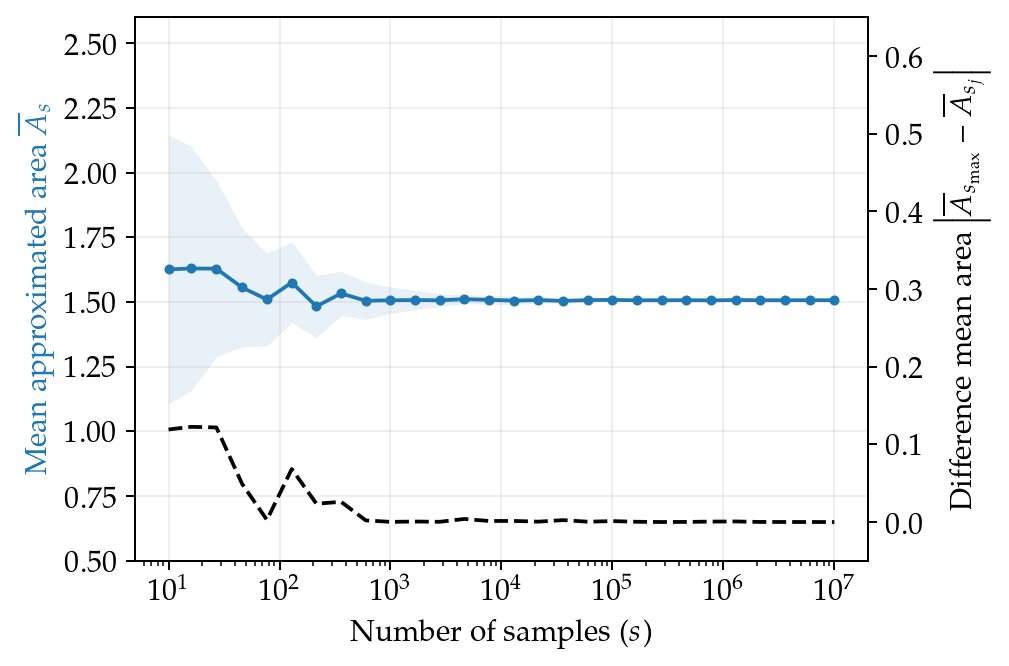

In [56]:
Plotter_S(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

In [57]:
#%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/I_iter")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 1, I_max_exp = 7, seed = 4345)
#shelf["Approx_areas_list_I_Uni"] = Approx_areas_list_I_Uni
#shelf["iteration_range_I_Uni"] = iteration_range_I_Uni
#shelf.close()

In [58]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_Uni = shelf["Approx_areas_list_I_Uni"]
iteration_range_I_Uni = shelf["iteration_range_I_Uni"]
shelf.close()

In [59]:
Statistics_print(Approx_areas_list_I_Uni, iteration_range_I_Uni)

Means:  [2.10092736 1.8206496  1.66665408 1.59819072 1.56006144 1.54390656
 1.5300768  1.51243008 1.52029248 1.5079008  1.51122048 1.5091776
 1.51447296 1.50452736 1.51204032 1.51023936 1.50647616 1.51263168
 1.51183872 1.51029312 1.50647616 1.50073728 1.513344   1.50815616
 1.50310272 1.50466176 1.50459456 1.50079104]
Error:  [6.0013632e-01 3.1985856e-01 1.6586304e-01 9.7399680e-02 5.9270400e-02
 4.3115520e-02 2.9285760e-02 1.1639040e-02 1.9501440e-02 7.1097600e-03
 1.0429440e-02 8.3865600e-03 1.3681920e-02 3.7363200e-03 1.1249280e-02
 9.4483200e-03 5.6851200e-03 1.1840640e-02 1.1047680e-02 9.5020800e-03
 5.6851200e-03 5.3760000e-05 1.2552960e-02 7.3651200e-03 2.3116800e-03
 3.8707200e-03 3.8035200e-03 0.0000000e+00]
Confidence radius:  [0.018424808294304817, 0.016315857398144118, 0.012552744891379586, 0.01939747822134752, 0.017134049256378958, 0.01653194867345542, 0.013750634770868686, 0.015392925028046012, 0.01435373156306774, 0.019345287067544348, 0.013556138220368386, 0.0149796776

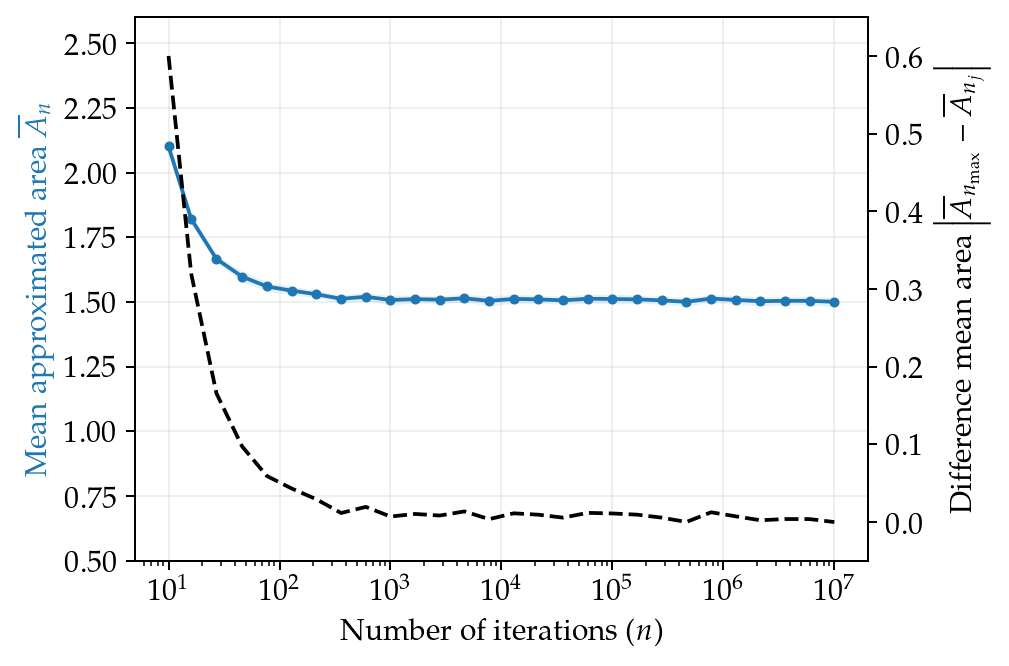

In [60]:
Plotter_I(Approx_areas_list_I_Uni, iteration_range_I_Uni)

### Comparison sampling techniques 

#### Varying the number of simulation runs - PRS, LHS and OS

In [61]:
##%%time
#shelf = shelve.open("Final_arrays_simulations/R_iter")
#Dic_PRS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = uniform_sampler, seed=983752)
#Dic_LHS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = latin_square_sampler, seed=796)
#Dic_OS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = orthogonal_sampler, seed=63723)

#shelf["Dic_PRS"] = Dic_PRS
#shelf["Dic_LHS"] = Dic_LHS
#shelf["Dic_OS"] = Dic_OS
#shelf["runs_size_range"] = runs_size_range
#shelf.close()

In [62]:
#Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/R_iter")
Dic_PRS = shelf["Dic_PRS"]  
Dic_LHS = shelf["Dic_LHS"]  
Dic_OS = shelf["Dic_OS"]
shelf.close()

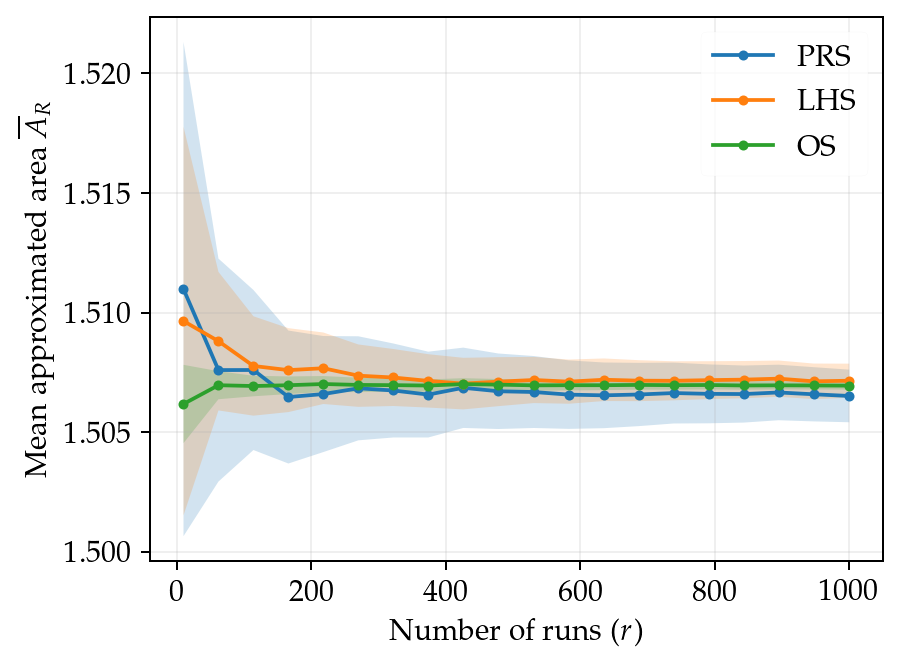

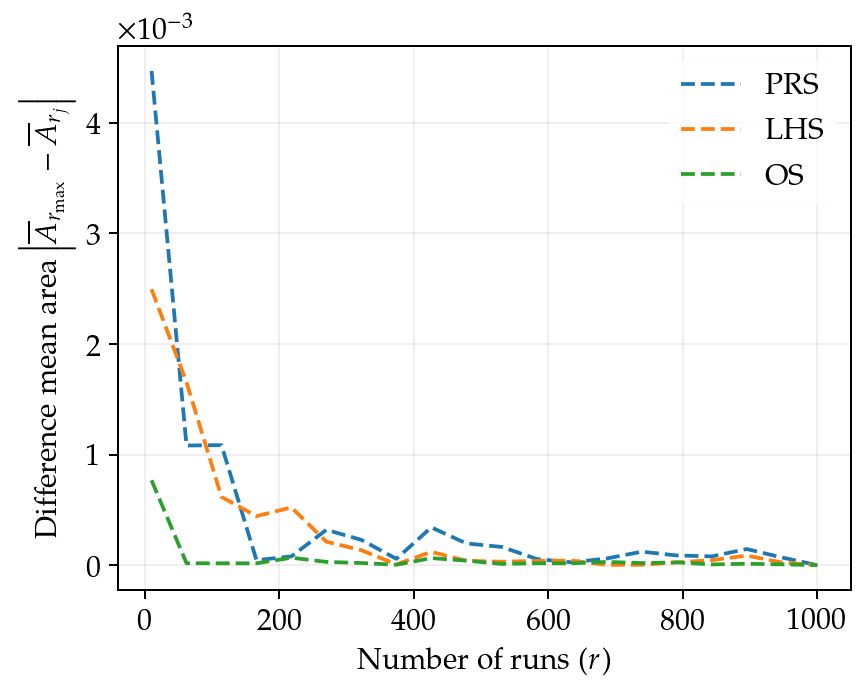

In [63]:
Plotter_N(Dic_PRS, Dic_LHS, Dic_OS)

#### Varying the number of simulation runs - OS and RQMC

In [64]:
#%%time
#shelf = shelve.open("Final_arrays_simulations/Quasi_vs_OS")
#Dic_Quasi_sobol, runs_size_range = N_iter(int(2**17), int(1e4), sampling_method = scrambled_sobol_sampler, seed=14512)
#shelf["Dic_Quasi_sobol"] = Dic_Quasi_sobol
#Dic_OS, runs_size_range = N_iter(int(2**17), int(1e4), sampling_method = orthogonal_sampler, seed=7320)
#shelf["Dic_OS"] = Dic_OS
#shelf["runs_size_range"] = runs_size_range
#shelf.close()

In [65]:
#Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/Quasi_vs_OS")
Approx_areas_list_Quasi = shelf["Dic_Quasi"]
Approx_areas_list_OS = shelf["Dic_OS"]
Approx_areas_list_Quasi_sobol = shelf["Dic_Quasi_sobol"] 
shelf.close()

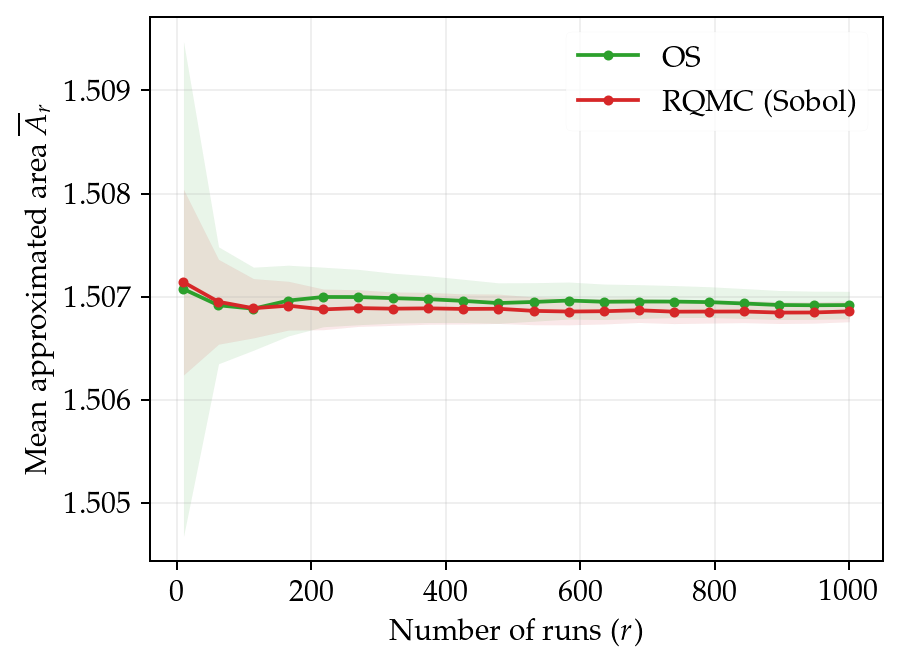

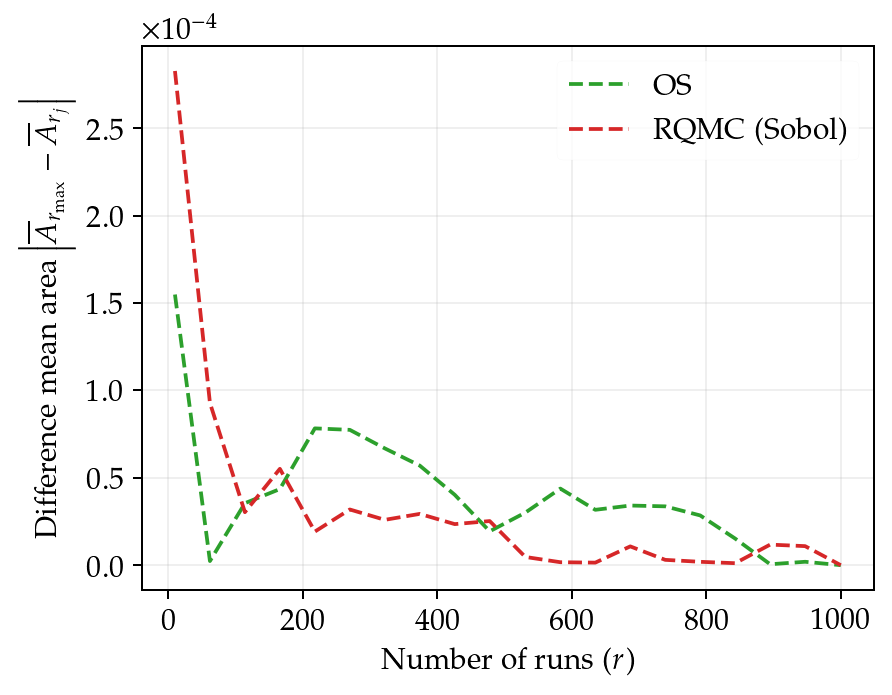

In [66]:
Plotter_N_Quasi(Approx_areas_list_Quasi, Approx_areas_list_OS, Approx_areas_list_Quasi_sobol)

### Statistical Tests and plots

In [67]:
#%%time
#Chosen samples
#Estimator after convergence (10^5 samples, 10^4 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, steps = 1, seed=22019)
#Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= latin_square_sampler, steps = 1, seed=7682932)
#Approx_areas_list_I_OS, iteration_range_I_OS = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= orthogonal_sampler, steps = 1, seed=672391)
#shelf["Approx_area_S_10^5_I_10^4_LHS"] = Approx_areas_list_I_LHS
#shelf["Approx_area_S_10^5_I_10^4_Uni"] = Approx_areas_list_I_Uni
#shelf["Approx_area_S_10^5_I_10^4_OS"] = Approx_areas_list_I_OS
#shelf.close()

#####  Boxplots and histograms for PRS-LHS-OS

In [68]:
#Open objects to work with
shelf = shelve.open("Final_arrays_simulations/Final_samples")
Approx_areas_list_LHS_Av_est = shelf["Approx_area_S_10^5_I_10^4_LHS"] 
Approx_areas_list_Uni_Av_est = shelf["Approx_area_S_10^5_I_10^4_Uni"] 
Approx_areas_list_OS_Av_est = shelf["Approx_area_S_10^5_I_10^4_OS"] 
shelf.close()

#Put list in right format (meaning not a list of list)
Approx_areas_list_Uni_Av_est = sum(Approx_areas_list_Uni_Av_est, [])
Approx_areas_list_LHS_Av_est = sum(Approx_areas_list_LHS_Av_est, [])
Approx_areas_list_OS_Av_est = sum(Approx_areas_list_OS_Av_est, [])

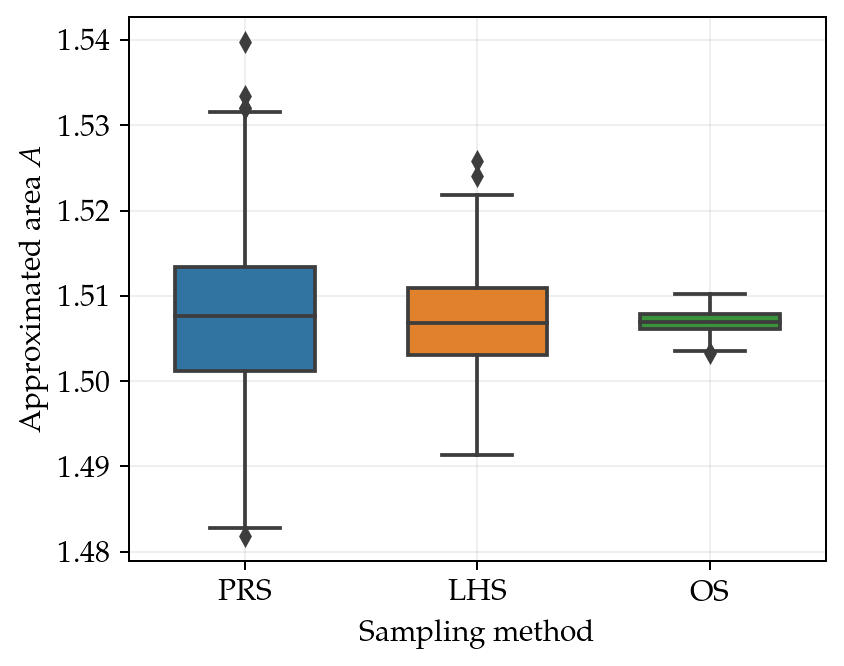

In [69]:
#Code to create the boxplots
fig = plt.figure(figsize=(5, 4))

#Put the lists in the right format for the sns.boxplot library
Values_Uniform = np.array(Approx_areas_list_Uni_Av_est)
Values_LHS = np.array(Approx_areas_list_LHS_Av_est)
Values_OS = np.array(Approx_areas_list_OS_Av_est)
Data_uniform = np.array([np.repeat("PRS", len(Values_Uniform)), Values_Uniform])
Data_LHS = np.array([np.repeat("LHS", len(Values_LHS)), Values_LHS])
Data_OS = np.array([np.repeat("OS", len(Values_OS)), Values_OS])
Data = np.concatenate([Data_uniform, Data_LHS, Data_OS], axis = 1)

#create a pandas dataframe
df = pd.DataFrame(Data.T, columns = ["Sampling methods", "Approximated Area"])
df = df.astype({"Approximated Area" : float})
ax = sns.boxplot(x="Sampling methods", y="Approximated Area",  data=df, width = 0.6, zorder=3)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
plt.ylabel("Approximated area $A$")
plt.xlabel("Sampling method")

if TEX_PLOTS:
    plt.savefig('figures/boxplot_sampling_differences.pdf',  bbox_inches='tight')
    
plt.show()

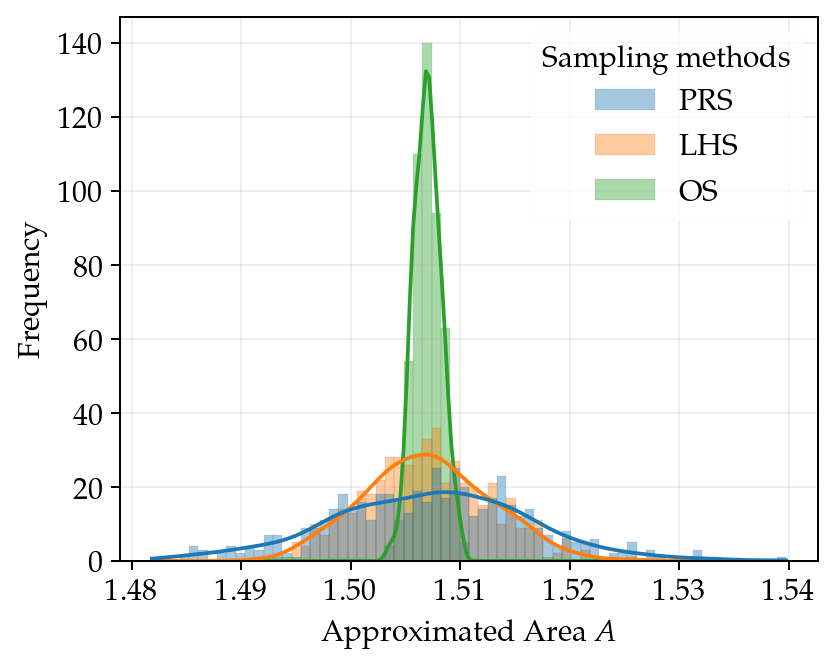

In [70]:
#Creates a histogram from the data 
fig = plt.figure(figsize=(5, 4))
plt.grid(alpha = 0.2)
sns.set_context(rc = {'patch.linewidth': 0.03})
sns.histplot(data = df, hue="Sampling methods", x="Approximated Area", alpha=0.4, kde = True)
plt.ylabel("Frequency")
plt.xlabel("Approximated Area $A$")
if TEX_PLOTS:
    plt.savefig('figures/dist_sampling_differences.pdf',  bbox_inches='tight')
plt.show()

In [71]:
#Generates a table of some basic statistics
Mean_Uni = np.mean(Approx_areas_list_Uni_Av_est) 
a_Uni = sp_confidence_interval(Approx_areas_list_Uni_Av_est)
Var_Uni = np.var(Approx_areas_list_Uni_Av_est, ddof = 1)

Mean_LHS = np.mean(Approx_areas_list_LHS_Av_est) 
a_LHS = sp_confidence_interval(Approx_areas_list_LHS_Av_est)
Var_LHS = np.var(Approx_areas_list_LHS_Av_est, ddof = 1)

Mean_OS = np.mean(Approx_areas_list_OS_Av_est) 
a_OS = sp_confidence_interval(Approx_areas_list_OS_Av_est)
Var_OS = np.var(Approx_areas_list_OS_Av_est, ddof = 1)

table = pd.DataFrame(np.array([[Mean_Uni, Mean_LHS, Mean_OS], [a_Uni, a_LHS, a_OS], [Var_Uni, Var_LHS, Var_OS]]), 
                  columns=['PRS', 'LHS', 'OS'], index = ['Mean', 'Radius', 'Variance'])

display(table)

,PRS,LHS,OS
Mean,1.507208,1.507006,1.506981
Radius,0.001587,0.001011,0.000218
Variance,0.000082,0.000033,0.000002


#####  Boxplots and histograms for OS-QRMC

In [72]:
#%%time
#Chosen samples
#Estimator after convergence (10^5 samples, 10^4 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_OS_2_power, iteration_range_I_OS_2_power = I_iter(sample_size = int(2**17), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= orthogonal_sampler, steps = 1, seed=672391)
#Approx_areas_list_I_QMS_2_power_sobol, iteration_range_I_QMS_2_power_sobol = I_iter(sample_size = int(2**17), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= scrambled_sobol_sampler, steps = 1, seed=672391)

#shelf["Approx_area_S_10^5_2_power_OS"] = Approx_areas_list_I_OS_2_power
#shelf["Approx_area_S_10^5_2_power_QMS_sobol"] = Approx_areas_list_I_QMS_2_power_sobol
#shelf.close()

In [73]:
#Open objects to work with
shelf = shelve.open("Final_arrays_simulations/Final_samples")
Approx_areas_list_I_OS_2_power = shelf["Approx_area_S_10^5_2_power_OS"] 
Approx_areas_list_I_QMS_2_power = shelf["Approx_area_S_10^5_2_power_QMS_sobol"]
shelf.close()

#Put list in right format (meaning not a list of lists)
Approx_areas_list_OS_Av_est_2_power = sum(Approx_areas_list_I_OS_2_power, [])
Approx_areas_list_QMS_av_est_2_power = sum(Approx_areas_list_I_QMS_2_power, [])

In [74]:
#Generates a table of some basic statistics
Mean_OS = np.mean(Approx_areas_list_OS_Av_est_2_power) 
a_OS = sp_confidence_interval(Approx_areas_list_OS_Av_est_2_power)
Var_OS = np.var(Approx_areas_list_OS_Av_est_2_power, ddof = 1)

Mean_QMS = np.mean(Approx_areas_list_QMS_av_est_2_power) 
a_QMS = sp_confidence_interval(Approx_areas_list_QMS_av_est_2_power)
Var_QMS = np.var(Approx_areas_list_QMS_av_est_2_power, ddof = 1)


table = pd.DataFrame(np.array([[Mean_OS, Mean_QMS], [a_OS, a_QMS], [Var_OS, Var_QMS]]), 
                  columns=[ 'OS', 'RQMC (Sobol)'], index = ['Mean', 'Radius', 'Variance'])

display(table)

,OS,RQMC (Sobol)
Mean,1.506963,1.506909e+00
Radius,0.000195,1.499143e-04
Variance,0.000001,7.277645e-07


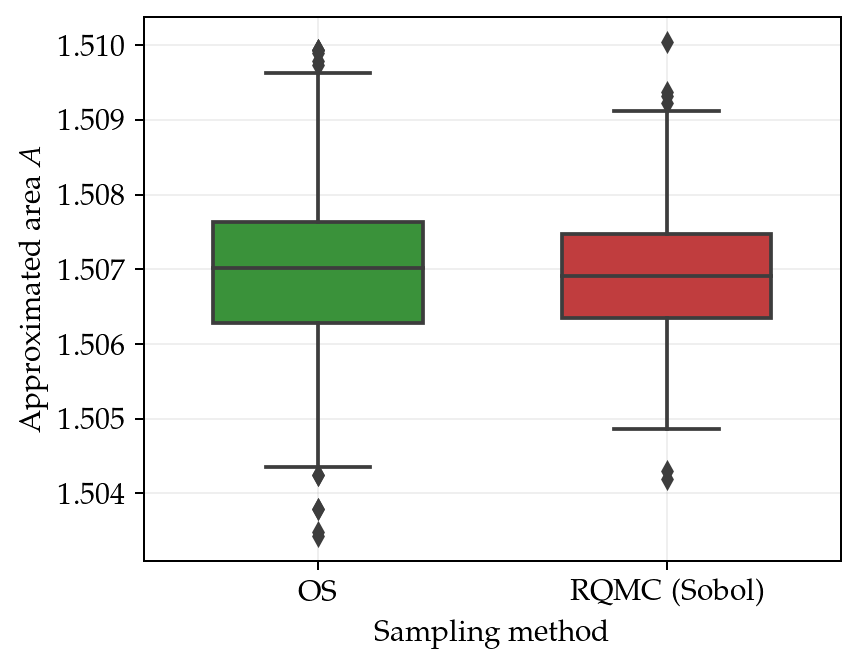

In [75]:
#Code to create the boxplots
fig = plt.figure(figsize=(5, 4))

#Put the lists in the right format for the sns.boxplot library
Values_OS = np.array(Approx_areas_list_OS_Av_est_2_power)
Values_QMS = np.array(Approx_areas_list_QMS_av_est_2_power)
Data_OS = np.array([np.repeat("OS", len(Values_OS)), Values_OS])
Data_QMS = np.array([np.repeat("RQMC (Sobol)", len(Values_QMS)), Values_QMS])
Data = np.concatenate([Data_OS, Data_QMS], axis = 1)

#create a pandas dataframe
df_qmc = pd.DataFrame(Data.T, columns = ["Sampling methods", "Approximated Area"])
df_qmc = df_qmc.astype({"Approximated Area" : float})
ax = sns.boxplot(x="Sampling methods", y="Approximated Area",  data=df_qmc, width = 0.6, zorder=3,
                 palette={"OS": "tab:green", "RQMC (Sobol)": "tab:red"})
plt.grid(alpha = 0.2, zorder=0)
ax.set_axisbelow(True)
plt.ylabel("Approximated area $A$")
plt.xlabel("Sampling method")

if TEX_PLOTS:
    plt.savefig('figures/boxplot_qmc_differences.pdf',  bbox_inches='tight')
    
plt.show()

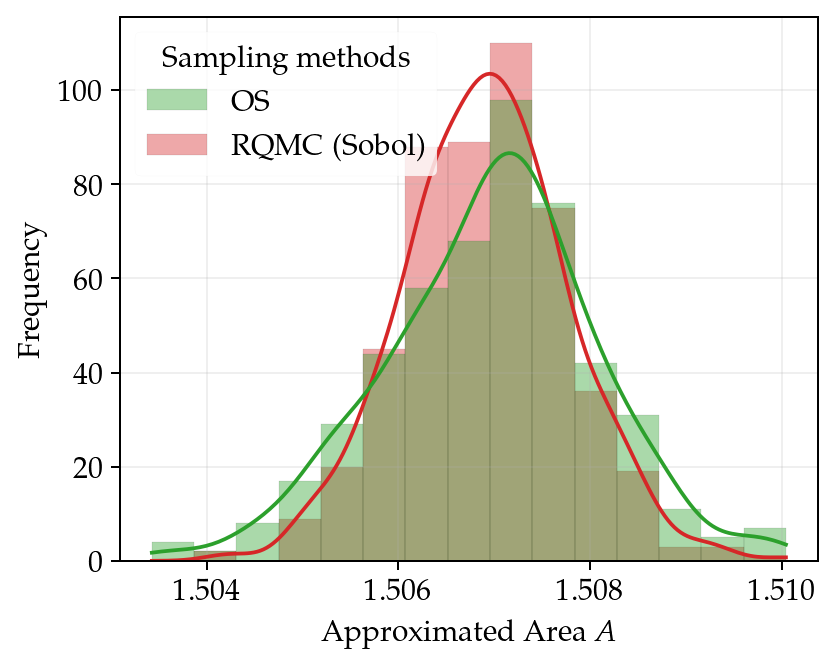

In [76]:
#Creates a histogram from the data 
fig = plt.figure(figsize=(5, 4))
plt.grid(alpha = 0.2)
sns.set_context(rc = {'patch.linewidth': 0.03})
sns.histplot(data = df_qmc, hue="Sampling methods", x="Approximated Area", alpha=0.4, kde = True,
             palette={"OS": "tab:green", "RQMC (Sobol)": "tab:red"}, bins=15)
plt.ylabel("Frequency")
plt.xlabel("Approximated Area $A$")

if TEX_PLOTS:
    plt.savefig('figures/dist_qmc_differences.pdf',  bbox_inches='tight')
plt.show()

### Statistical test (F-test and Welch's Test)

In [77]:
#Our chosen alpha value for the tests
alpha = 0.05

#Welch tests
statistic_1a, p_value_1a = scipy.stats.ttest_ind(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est, equal_var = False)
statistic_2a, p_value_2a = scipy.stats.ttest_ind(Approx_areas_list_Uni_Av_est, Approx_areas_list_OS_Av_est, equal_var = False)
statistic_3a, p_value_3a = scipy.stats.ttest_ind(Approx_areas_list_LHS_Av_est, Approx_areas_list_OS_Av_est, equal_var = False)
statistic_4a, p_value_4a = scipy.stats.ttest_ind(Approx_areas_list_QMS_av_est_2_power, Approx_areas_list_OS_Av_est_2_power, equal_var = False)


#F tests
statistic_1b, p_value_1b = F_test(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est)
statistic_2b, p_value_2b = F_test(Approx_areas_list_Uni_Av_est, Approx_areas_list_OS_Av_est)
statistic_3b, p_value_3b = F_test(Approx_areas_list_LHS_Av_est, Approx_areas_list_OS_Av_est)
statistic_4b, p_value_4b = F_test(Approx_areas_list_QMS_av_est_2_power, Approx_areas_list_OS_Av_est_2_power)


reject_a, pvals_corrected_a, alphacSidak_a, alphacBonf_a = multitest.multipletests(pvals = [p_value_1a, p_value_2a, p_value_3a, p_value_4a], alpha = alpha, method = "bonferroni")
print(reject_a, pvals_corrected_a, alphacSidak_a, alphacBonf_a)
print("Corrected Alpha: ", alphacBonf_a)

reject_b, pvals_corrected_b, alphacSidak_b, alphacBonf_b = multitest.multipletests(pvals = [p_value_1b, p_value_2b, p_value_3b, p_value_4b], alpha = alpha, method = "bonferroni")
print(reject_b, pvals_corrected_b, alphacSidak_b, alphacBonf_b)
print("Corrected Alpha: ", alphacBonf_b)

print("Statistics Comparison PRS and LHS")
print("Welch-Test: ")
print("Statistic: ", statistic_1a, ", with p-value :", p_value_1a)
print("F-Test: ")
print("Statistic :", statistic_1b, ", with p-value :", p_value_1b, "\n")

print("Statistics Comparison PRS and OS")
print("Welch-Test: ")
print("Statistic: ", statistic_2a, ", with p-value :", p_value_2a)
print("F-Test: ")
print("Statistic :", statistic_2b, ", with p-value :", p_value_2b, "\n")

print("Statistics Comparison OS and LHS")
print("Welch-Test: ")
print("Statistic: ", statistic_3a, ", with p-value :", p_value_3a)
print("F-Test: ")
print("Statistic :", statistic_3b, ", with p-value :", p_value_3b, "\n")

print("Statistics Comparison QRS and OS")
print("Welch-Test: ")
print("Statistic: ", statistic_4a, ", with p-value :", p_value_4a)
print("F-Test: ")
print("Statistic :", statistic_4b, ", with p-value :", p_value_4b, "\n")


[False False False False] [1. 1. 1. 1.] 0.012741455098566168 0.0125
Corrected Alpha:  0.0125
[ True  True  True  True] [4.44089210e-16 4.44089210e-16 4.44089210e-16 1.15488494e-08] 0.012741455098566168 0.0125
Corrected Alpha:  0.0125
Statistics Comparison PRS and LHS
Welch-Test: 
Statistic:  0.42236138880326035 , with p-value : 0.6728685028229762
F-Test: 
Statistic : 2.4659172744457156 , with p-value : 1.1102230246251565e-16 

Statistics Comparison PRS and OS
Welch-Test: 
Statistic:  0.5560728238972809 , with p-value : 0.5784012817594419
F-Test: 
Statistic : 53.10537502854247 , with p-value : 1.1102230246251565e-16 

Statistics Comparison OS and LHS
Welch-Test: 
Statistic:  0.09295487806624549 , with p-value : 0.9259735527029285
F-Test: 
Statistic : 21.53574881804557 , with p-value : 1.1102230246251565e-16 

Statistics Comparison QRS and OS
Welch-Test: 
Statistic:  -0.8603634629547425 , with p-value : 0.38980893889761525
F-Test: 
Statistic : 1.689753573743472 , with p-value : 2.8872123